# Analysis of Arlington County Bus Routes

## Data sources
<a href="https://api.census.gov/data/2010/sf1/?get=P0120001&for=block:*&in=state:51%20county:013">2010 US Census</a>
<a href="https://www2.census.gov/geo/tiger/TIGER2010/TABBLOCK/2010/">TIGER/Line shapefiles</a>

## Organize and pre-process data
We need to take the raw population data, which is provided on a US Census Block level, and map that to latitude and longitude. We can do this via TIGER/Line shapefiles. I have preloaded the data into 2 files, so no API request is required. We will save the original Census data, along with the bounding box for each block and the centroid (calculated from the bounding box). All of this is done within the BetterBus class. We implement an OOP structure so that frequently referenced objects, like the population data, can be referenced as internal variables rather than parameters or global variables.

### Extrapolating population points
Our raw data includes population numbers and locations, but this does not work well with the built-in scikit-learn k-means algorithm. Therefore we have to create a new array with 1 entry per person, essentially multiplying each lat/lon by the number of people who live there. We uniformly distribute these points within the bounding box for that census block so they don't all lie exactly on top of each other. All of this is done within the gen_arr() method.

In [1]:
import re
import random as rnd
import shapefile
import numpy as np
import pandas as pd
import sklearn.cluster as sk_cl
import matplotlib.pyplot as plt
import networkx as nx
import time
import math


class BetterBus:
    # TODO: Random state not working?
    def __init__(self):
        """
        Set random_state to ensure repeatable outcome.

        https://towardsdatascience.com/clustering-the-us-population-observation-weighted-k-means-f4d58b370002
        https://catalog.data.gov/dataset/current-business-license-list-c47fc/resource/731119ac-0df7-44b1-b4f3-148e2693121e
        https://geocoding.geo.census.gov/geocoder/
        https://wiki.openstreetmap.org/wiki/Downloading_data
        Arlington bounding box (left, bottom, right, top):
        arl_bbox = ['-77.1723251343','38.8272895813',
                    '-77.032081604','38.9342803955']
        'https://api.openstreetmap.org/api/0.6/map?bbox=' + ','.join(arl_bbox)
        Look for building tags to estimate demand.
        https://wiki.openstreetmap.org/wiki/Map_Features#Building
        Bus stops Arlington County VA catalog.data.gov
        """
        ts = time.time()
        rnd.seed(1)
        plt.style.use('ggplot')
        self.sfile = 'tl_2010_51013_tabblock10/tl_2010_51013_tabblock10.shp'
        try:
            self.read_arr()
        except Exception as e:
            print(e)
            self.gen_df()
            self.gen_arr()
        te = time.time()
        print('__init__() complete in {0} sec'.format(te - ts))

    def calc_centroid(self, points_arr):
        """
        Define a function to calculate the centroid from a numpy array of
        points.
        """
        ts = time.time()
        length = points_arr.shape[0]
        sum_x = np.sum(points_arr[:, 0])
        sum_y = np.sum(points_arr[:, 1])
        return sum_x / length, sum_y / length
        te = time.time()
        print('calc_centroid() complete in {0} sec'.format(te - ts))

    def gen_df(self):
        """
        Download population data from US Census API
        VA = 51, Arlington county = 013, Total population = P0120001
        https://api.census.gov/data/2010/sf1/?get=P0120001&for=block:*&in=state:51%20county:013
        Input data has extra [, ], and " characters, so strip those.
        lines[0] is the header row, so skip it.

        Open TIGER/Line data shapefile for Arlington County, VA
        https://www2.census.gov/geo/tiger/TIGER2010/TABBLOCK/2010/
        Pyshp: https://pypi.python.org/pypi/pyshp used as import shapefile
        Shapefile length matches US Census API results length.
        This leads me to believe that index i in the API results maps to shape
        i in the shapefile.
        Create an index variable to map back to API data.
        Convert shapefile points to numpy array for processing in
        calc_centroid.
        """
        ts = time.time()
        data = []
        with open('census_api_resp.json', 'r') as fid:
            lines = fid.readlines()
            for line in lines[1:]:
                line = re.sub(r'\[|\]|"', '', line).rstrip(',\n')
                pop, state, county, tract, block = line.split(',')
                data.append({'pop': int(pop),
                             'state': state,
                             'county': county,
                             'tract': tract,
                             'block': block})
        sfile = 'tl_2010_51013_tabblock10/tl_2010_51013_tabblock10.shp'
        sf = shapefile.Reader(sfile)
        shapes = sf.shapes()
        indx = 0
        for shape in shapes:
            arr = np.array(shape.points)
            lat, lon = self.calc_centroid(arr)
            lon_1, lat_1, lon_2, lat_2 = shape.bbox
            data[indx]['cent_lat'] = lat
            data[indx]['cent_lon'] = lon
            data[indx]['bbox_lat1'] = lat_1
            data[indx]['bbox_lat2'] = lat_2
            data[indx]['bbox_lon1'] = lon_1
            data[indx]['bbox_lon2'] = lon_2
            indx += 1
        self.df = pd.DataFrame(data)
        with pd.HDFStore('store.h5') as store:
            store['df'] = self.df
        self.df.to_pickle('store.pkl')
        te = time.time()
        print('gen_df() complete in {0} sec'.format(te - ts))

    def read_df(self):
        ts = time.time()
        try:
            with pd.HDFStore('store.h5') as store:
                self.df = store['df']
        except Exception as e:
            print(e)
        te = time.time()
        print('read_df() complete in {0} sec'.format(te - ts))

    def gen_arr(self):
        """
        To accurately represent population weights, multiply the location
        data by the population. E.g. (36, -77, 120) becomes 120 copies
        of (36, -77).
        Each population point will be randomly distributed within the
        bounding box for that block.
        """
        ts = time.time()
        data = []
        for indx, row in self.df.iterrows():
            for _ in range(int(row['pop'])):
                lat = rnd.uniform(row.loc['bbox_lat1'], row.loc['bbox_lat2'])
                lon = rnd.uniform(row.loc['bbox_lon1'], row.loc['bbox_lon2'])
                data.append([lat, lon])
        self.arr = np.array(data)
        np.save('arr_file', self.arr)
        te = time.time()
        print('gen_arr() complete in {0} sec'.format(te - ts))

    def read_arr(self):
        ts = time.time()
        self.arr = np.load('arr_file.npy')
        te = time.time()
        print('read_arr() complete in {0} sec'.format(te - ts))

    def get_dist(self, p1, p2):
        """
        Returns Haversine distance (in km) between two lat/lon tuples.

        https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula
        """
        r = 6384
        # Pi/180
        p = 0.017453292519943295
        a = 0.5 - math.cos((p2[0] - p1[0]) * p) / 2 + math.cos(p1[0] * p) * \
            math.cos(p2[0] * p) * (1 - math.cos((p2[1] - p1[1]) * p)) / 2
        return 2 * r * math.asin(math.sqrt(a))

    def valid_route(self, route):
        """
        Returns False if the route has sub-tours or same-node edges.
        """
        edges = []
        for edge in route:
            if edge[0] == edge[1]:
                return False
            if len(edges) > 0 and edge[0] != edges[-1][1]:
                return False
            edges.append(edge)
        return True

    def swap(self, route, i, j):
        new_route = route[:i]
        new_route.append((route[i][0], route[j][0]))
        for indx in range(j - 1, i, -1):
            edge = route[indx]
            new_route.append((edge[1], edge[0]))
        new_route.append((route[i][1], route[j][1]))
        new_route += route[j + 1:]
        return new_route

    def two_opt(self, graph, pos):
        route = list(graph.edges())
        dist = sum([self.get_dist(pos[e[0]], pos[e[1]]) for e in route])
        i1 = 0
        while i1 < len(route) - 2:
            i2 = i1 + 1
            while i2 < len(route):
                new_route = self.swap(route, i1, i2)
                new_dist = sum([self.get_dist(pos[e[0]], pos[e[1]])
                                for e in new_route])
                if new_dist < dist and self.valid_route(new_route):
                    route = new_route
                    dist = new_dist
                    i1 = 0
                    break
                i2 += 1
            i1 += 1
        edges = [(e[0], e[1], self.get_dist(pos[e[0]], pos[e[1]]))
                 for e in route]
        tsp = nx.Graph()
        tsp.add_weighted_edges_from(edges)
        return tsp

    def christofides(self, points, show_steps=False, show_final=False):
        """
        Algorithm:
        1) Create minimum spanning tree of graph
        2) Find all nodes with odd degree (odd number of edges)
        3) Create minimum weight perfect matching graph of nodes from 2)
        4) Combine graphs from 1) and 3) (all nodes should have even degree)
        5) Remove (skip) repeated nodes
        6) Improve result with 2-opt

        Returns NetworkX Graph object with ~TSP edges.
        """
        ts = time.time()
        pos = {i: (p[1], p[0]) for i, p in enumerate(points)}
        edges = [(i, j, self.get_dist(p1, p2)) for i, p1 in enumerate(points)
                 for j, p2 in enumerate(points)]
        G = nx.Graph()
        G.add_weighted_edges_from(edges)

        # Step 1)
        mst = nx.algorithms.minimum_spanning_tree(G)

        # Step 2)
        odds = [n for n in range(mst.number_of_nodes())
                if mst.degree(n) % 2 != 0]

        # Step 3)
        adj = np.array([[self.get_dist(pos[n1], pos[n2])
                         for n1 in odds] for n2 in odds])
        # Prevent self-selection
        np.fill_diagonal(adj, np.inf)
        # Prevent re-selection of existing edges
        for edge in mst.edges():
            if edge[0] in odds and edge[1] in odds:
                i = odds.index(edge[0])
                j = odds.index(edge[1])
                adj[i, j] = np.inf
                adj[j, i] = np.inf
        new_edges = []
        selected = []
        # Find minimum weight edges
        # np.argmin(adj, axis=1) includes duplicates, which we want to avoid
        for indx, row in enumerate(adj):
            # If a node was selected already, skip it
            if indx in selected:
                continue
            min_indx = np.argmin(adj, axis=1)[indx]
            n1 = odds[indx]
            n2 = odds[min_indx]
            new_edges.append((n1, n2, adj[indx, min_indx]))
            # Prevent double selection
            # Overwrite columns with np.inf and add to selected list
            adj[:, indx] = np.inf
            adj[:, min_indx] = np.inf
            selected.extend((indx, min_indx))

        # Step 4)
        mm_mst = mst.copy()
        mm_mst.add_weighted_edges_from(new_edges)

        # Step 5)
        p_node = 0
        n_node = 0
        nodelist = [n_node]
        edgelist = []
        edgestack = []
        while len(nodelist) < len(mm_mst.nodes()):
            for edge in mm_mst.edges(n_node):
                edgestack.insert(0, edge)
            while n_node in nodelist:
                n_node = edgestack.pop(0)[1]
            nodelist.append(n_node)
            edgelist.append((p_node, n_node))
            p_node = n_node
        tsp_edges = [(e[0], e[1], self.get_dist(pos[e[0]], pos[e[1]]))
                     for e in edgelist]
        wrap = (nodelist[-1], nodelist[0], self.get_dist(pos[nodelist[-1]],
                                                         pos[nodelist[0]]))
        tsp_edges.append(wrap)
        tsp = nx.DiGraph()
        tsp.add_weighted_edges_from(tsp_edges)

        # Step 6)
        old = tsp.copy()
        two_opt_ctr = 0
        while True:
            new = self.two_opt(old, pos)
            if list(new.edges()) == list(old.edges()):
                break
            old = new.copy()
            two_opt_ctr += 1
        print('two_opt() called {0} times'.format(two_opt_ctr))
        improved_tsp = new.copy()

        if show_steps:
            self.draw(mst, pos, 'mst')
            self.draw(mm_mst, pos, 'min matching mst')
            self.draw(tsp, pos, 'tsp')
            self.draw(improved_tsp, pos, 'improved tsp')
        elif show_final:
            self.draw(improved_tsp, pos, 'improved tsp')
        te = time.time()
        print('christofides() complete in {0} sec'.format(te - ts))
        return improved_tsp, pos

    def draw(self, graph, pos, title):
        """
        Takes a NetworkX Graph object, a dictionary of node positions,
        and a title.
        """
        ts = time.time()
        fig = plt.figure(figsize=(12, 8), dpi=120)
        ax = fig.add_subplot(111)
        ax.tick_params(axis='both', which='both', bottom='off',
                       top='off', labelbottom='off', right='off',
                       left='off', labelleft='off')
        ax.set(adjustable='box', aspect=0.75)
        ax.set_title(title, size=12)
        # Draw shapefile outlines
        sf = shapefile.Reader(self.sfile)
        for shape in sf.shapeRecords():
            x = [i[0] for i in shape.shape.points[:]]
            y = [i[1] for i in shape.shape.points[:]]
            plt.plot(x, y, linewidth=0.1)
        # Draw population dots
        ax.scatter(self.arr[:, 1], self.arr[:, 0], s=0.01, c='#5d8eec')
        # Draw input route
        nx.draw_networkx(graph, pos, node_color='#F95151', node_size=5,
                         with_labels=False)
        # plt.savefig(title, dpi=300)
        plt.show(block=False)
        te = time.time()
        print('draw() complete in {0} sec'.format(te - ts))

In [2]:
bb = BetterBus()

read_arr() complete in 0.004126071929931641 sec
__init__() complete in 0.0045506954193115234 sec


## K-means clustering
We want to find the best locations for bus stops and depots. To do this, we want to find clusters of where people live. We can do this with k-means clustering. This algorithm requires an array of data and a number of desired central points and will return the location for each of those centroids such that the average distance between the array data and the centroids is minimized. In order to improve performance, we are using a pre-built k-means algorithm with scikit-learn called MiniBatchKMeans. There is a stochastic element to this algorithm, so re-runs will not always return the same centroids.

In [3]:
n = 25
stops = sk_cl.MiniBatchKMeans(n_clusters=n).fit(bb.arr).cluster_centers_

## TSP heuristic
In order to plan routes between stops, we want to perform a <a href='https://en.wikipedia.org/wiki/Travelling_salesman_problem'>Traveling Salesman Problem (TSP)</a>. This generates a route that touches each node in a graph exactly once and returns to the starting node at the end, minimizing the total distance traveled. The TSP is an NP-hard problem, so true optimization is difficult without advanced computational resources.

### Christofides
However, there are many heuristics that provide good, if not optimal, solutions. One of these is <a href='https://en.wikipedia.org/wiki/Christofides_algorithm'>Christofides algorithm</a>, guaranteed to be within 3/2 of the optimal solution. It involves 5 major steps:
1. Create minimum spanning tree of graph
2. Find all nodes with odd degree (odd number of edges)
3. Create minimum weight perfect matching graph of nodes from step 2
4. Combine graphs from steps 1 and 3 (all nodes should have even degree)
5. Remove (skip) repeated nodes

### 2-opt improvement
The <a href='https://en.wikipedia.org/wiki/2-opt'>2-opt algorithm</a> is a local search and improvement algorithm for the TSP. It serves to effectively "uncross" crossed edges. We can apply this algorithm after the original TSP heuristic, in this case Christofides, to improve the solution. As the algorithm is a local improvement, it requires 3 inputs, a route, a start node, and an end node. Iterating on all the edges between the start and end node, we attempt to reverse the edges. If this results in a low total distance then we found an improvement.

two_opt() called 12 times


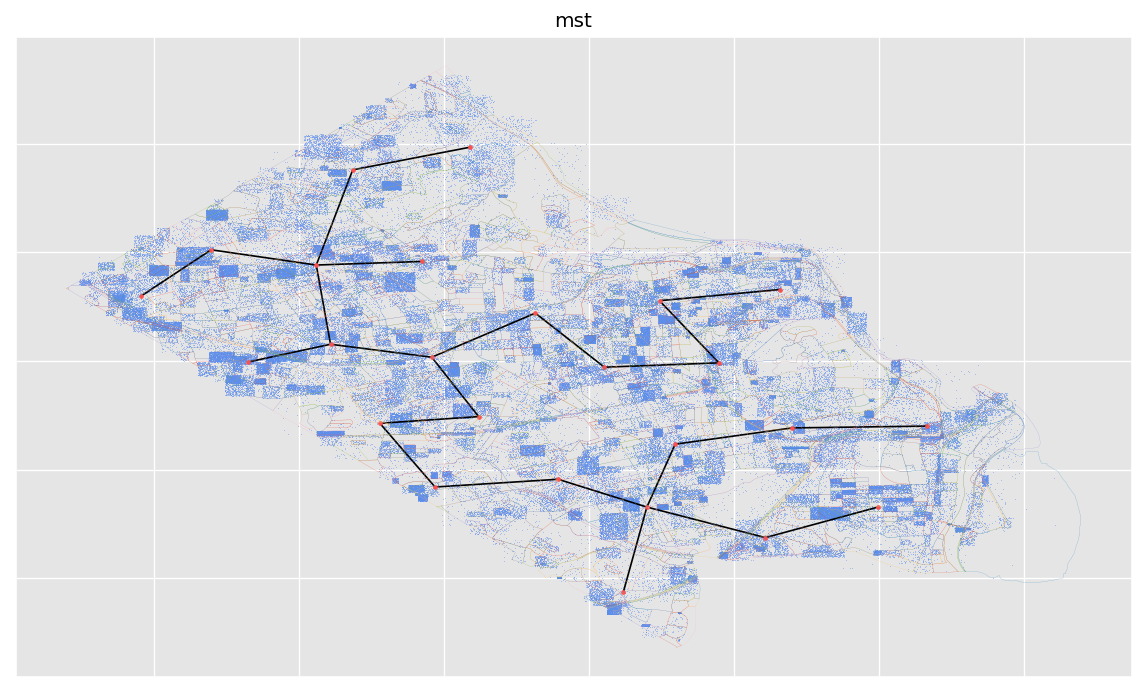

draw() complete in 9.87177586555481 sec


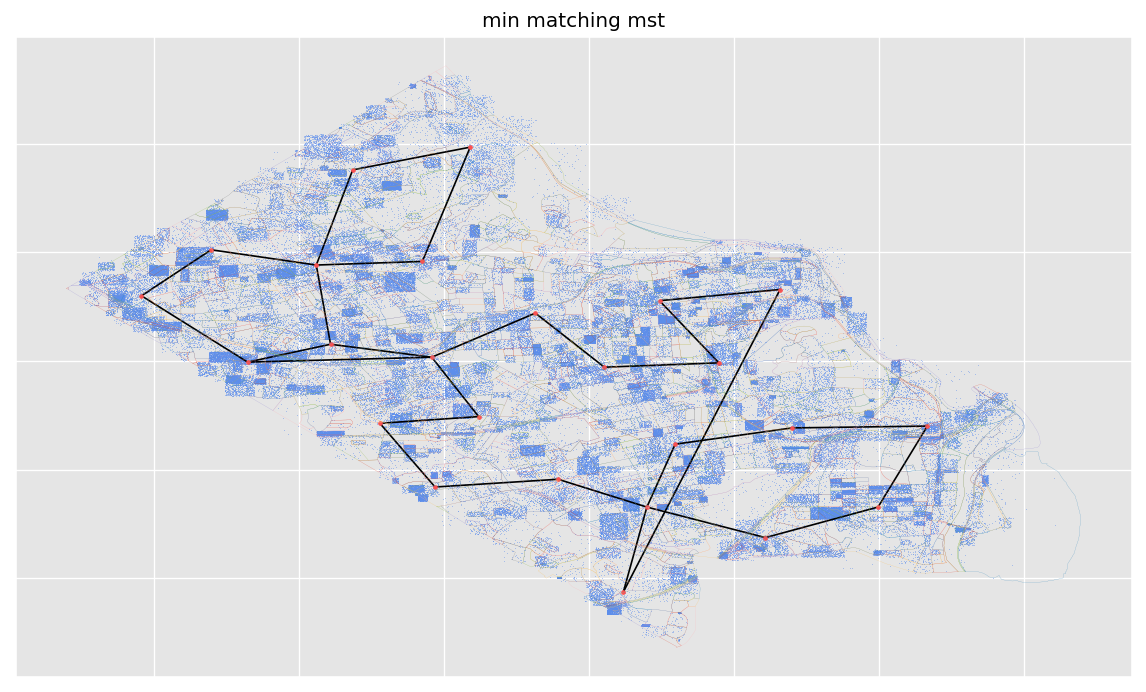

draw() complete in 10.033427953720093 sec


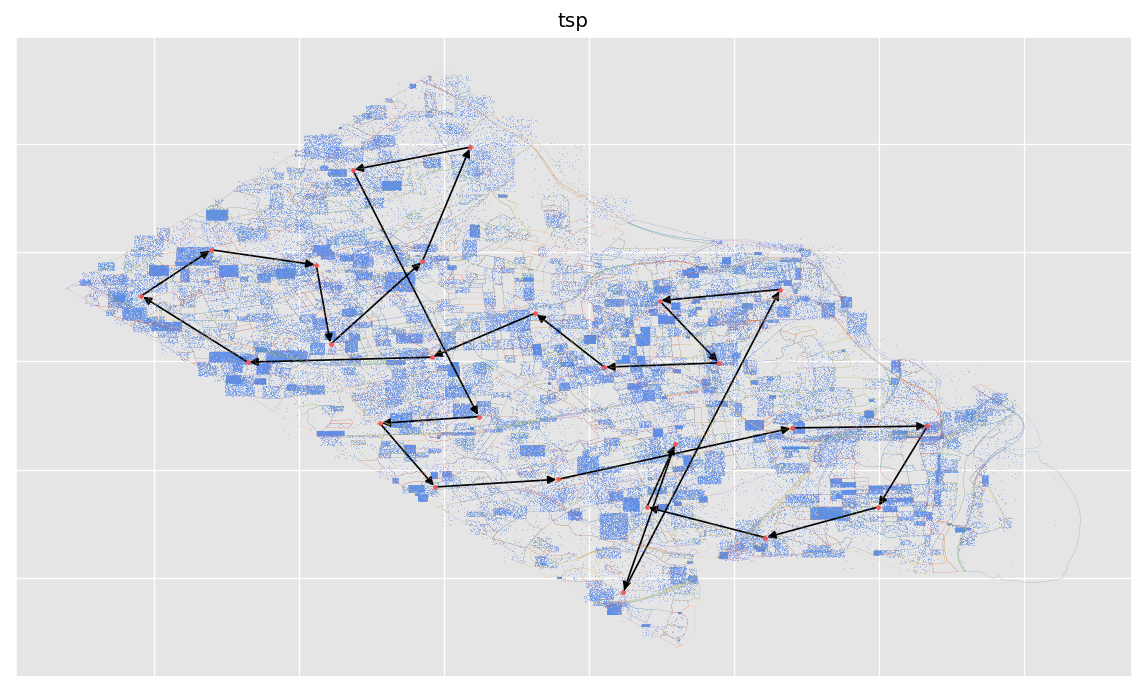

draw() complete in 10.406879901885986 sec


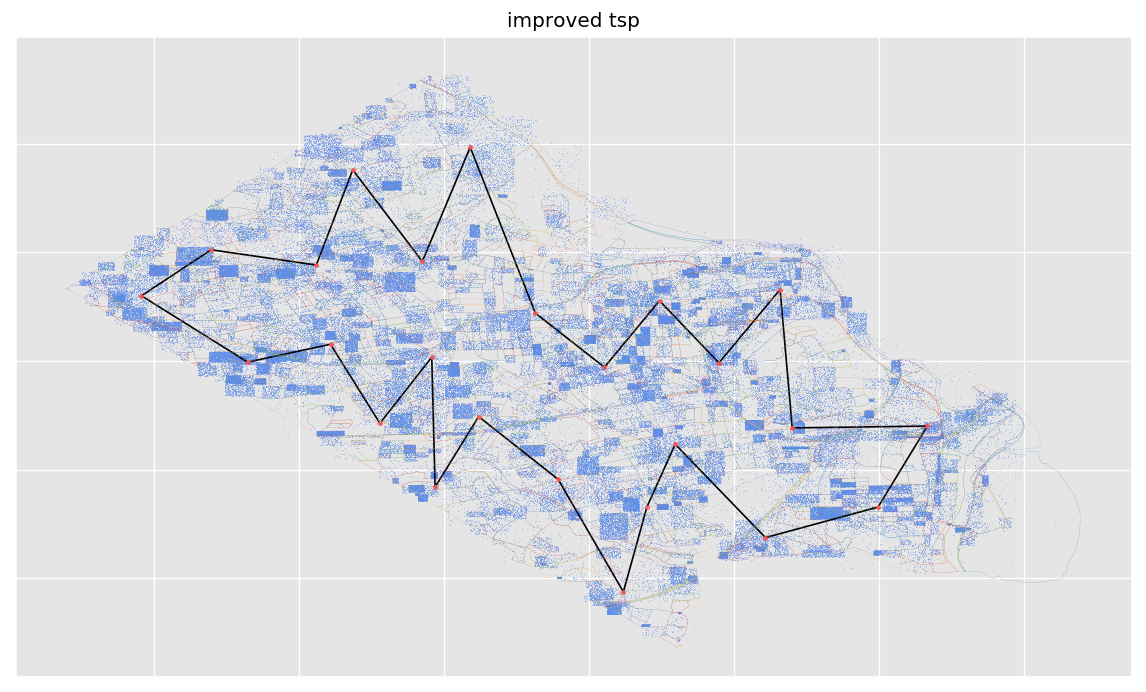

draw() complete in 9.699410915374756 sec
christofides() complete in 40.4539520740509 sec


In [4]:
tsp, pos = bb.christofides(stops, show_steps=True)